In [9]:
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as pp
import seaborn as sns
import numpy as np

get_ipython().magic(u'matplotlib inline')


In [10]:
#inspecting sensor data, remove empty columns and change datatype
data = pd.read_csv('sensor.csv')
#data.info()
#remove old index and column without any data
data = data.drop(['Unnamed: 0','sensor_15'], axis=1)
#convert date to datetime for timeseries and set as new index
data[['timestamp']] = data[['timestamp']].apply(pd.to_datetime)
ts = data.set_index('timestamp')

In [12]:
#check at which timepoints the machine was broken
ts_broken = ts[ts.machine_status == 'BROKEN']
list(ts_broken.index)
#the machine was broken at seven timepoints during 2018

[Timestamp('2018-04-12 21:55:00'),
 Timestamp('2018-04-18 00:30:00'),
 Timestamp('2018-05-19 03:18:00'),
 Timestamp('2018-05-25 00:30:00'),
 Timestamp('2018-06-28 22:00:00'),
 Timestamp('2018-07-08 00:11:00'),
 Timestamp('2018-07-25 14:00:00')]

In [13]:
# create a new class "before breaking/broken" : 10 minutes before breakdown

In [31]:
#fill in missing values, default is 'linear', treat values as equally spaced
ts_interpolated = ts.interpolate()

# create a new class "before breaking/broken" : 10 minutes before breakdown
temp = ts_interpolated['machine_status'].copy()

temp.loc[(temp.index >= pd.to_datetime('2018-04-12 21:45:00')) & (temp.index <= pd.to_datetime('2018-04-12 21:54:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-04-18 00:20:00')) & (temp.index <= pd.to_datetime('2018-04-18 00:29:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-05-19 03:08:00')) & (temp.index <= pd.to_datetime('2018-05-19 03:17:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-05-25 00:20:00')) & (temp.index <= pd.to_datetime('2018-05-25 00:29:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-06-28 21:50:00')) & (temp.index <= pd.to_datetime('2018-06-28 21:59:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-07-08 00:01:00')) & (temp.index <= pd.to_datetime('2018-07-08 00:10:00'))] = 'BEFORE_BREAKING'
temp.loc[(temp.index >= pd.to_datetime('2018-07-25 13:50:00')) & (temp.index <= pd.to_datetime('2018-07-25 13:59:00'))] = 'BEFORE_BREAKING'

ts_interpolated['machine_status'] = temp

#check result
#ts_interpolated.info()
#ts_interpolated[ts_interpolated['machine_status'] == 'BEFORE_BREAKING']

In [32]:
# unite 'before_breaking', 'broken' and 'recovering' to detect the abnormal classes : make it 2 class problem 
def make_status_abnormal(alarms): 
    if np.any(alarms == 'BEFORE_BREAKING'):
        return 1
    if np.any(alarms == 'BROKEN'):
        return 1
    if np.any(alarms == 'NORMAL'):
        return 0
    if np.any(alarms == 'RECOVERING'):
        return 1

In [34]:
#add new classes to dataframe
ts_interpolated['machine_status_new'] = ts_interpolated['machine_status'].apply(make_status_abnormal)

In [36]:
#check result
#ts_interpolated.info()

In [37]:
#Run Isolation Forest Algorithm on data to get Anomaly Score
from sklearn.ensemble import IsolationForest

In [38]:
#remove time, machine_status, machine_status_new from dataset
ts_interpolated_if = ts_interpolated.reset_index()
ts_interpolated_if = ts_interpolated_if.drop(['timestamp','machine_status','machine_status_new'],axis=1)
#run isolation forest algorithm on data
clf_if = IsolationForest(max_samples=100000, random_state=10)
clf_if.fit(ts_interpolated_if)
decision_func = clf_if.decision_function(ts_interpolated_if)
predicted = clf_if.predict(ts_interpolated_if)
#Return the anomaly score of each sample. Returns -1 for outliers and 1 for inliers.
ts_interpolated['anomaly_score'] = predicted
#ts_interpolated['decision_function'] = decision_func

In [62]:
#ts_interpolated.describe()
#ts_interpolated.info()

machine_status_new  anomaly_score
0                    1               191151
                    -1                14615
1                   -1                 7417
                     1                 7137
Name: anomaly_score, dtype: int64

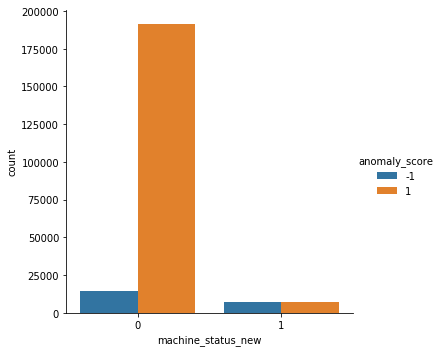

In [63]:
pp.rcParams['figure.figsize'] = [5, 5]

sns.catplot(x='machine_status_new', data=ts_interpolated, hue = "anomaly_score", kind="count")
grouped = ts_interpolated.groupby(['machine_status_new'])
grouped['anomaly_score'].value_counts()

# The anomaly score could be helpful in half of the cases

In [66]:
#Run Random Forest Algorithm on data 

In [67]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)

In [70]:
#split into training and test sets, train set will contain 5 breakdown events, test set will contain 2 breakdown events
ts_interpolated_train = ts_interpolated['2018-04-01':'2018-07-01']
ts_interpolated_train['machine_status_new'].value_counts()

0    122015
1     10465
Name: machine_status_new, dtype: int64

In [71]:
ts_interpolated_test = ts_interpolated['2018-07-02':]
ts_interpolated_test['machine_status_new'].value_counts()

0    83751
1     4089
Name: machine_status_new, dtype: int64

In [72]:
#generate feature list using all features, remove values to be predicted
feature_list = list(ts_interpolated.columns)
feature_list.remove('machine_status')
feature_list.remove('machine_status_new')
#feature_list

In [73]:
y_train = ts_interpolated_train['machine_status_new']
y_test = ts_interpolated_test['machine_status_new']

In [74]:
clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10)#, class_weight = "balanced")
#n_jobs:  -1 means using all processors
#random_state:
#n_estimators: The number of trees in the forest.
#not using balanced weights
clf_rf.fit(ts_interpolated_train[feature_list], y_train)

y_pred_rf = clf_rf.predict(ts_interpolated_test[feature_list])

In [75]:
from sklearn import metrics

cnf_matrix_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cnf_matrix_rf

#working: 99.6% of events correctly classified
#broken: 90.1% of events correctly classified

array([[83461,   290],
       [   37,  4052]])

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))
#good scores

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     83751
          1       0.93      0.99      0.96      4089

avg / total       1.00      1.00      1.00     87840



In [77]:
#Random Forest provides feature importance
rf_feature_importance = list(zip((clf_rf.feature_importances_) , ts_interpolated_test[feature_list]))
feature_imp = pd.DataFrame(rf_feature_importance)
feature_imp.columns =['score','feature']

In [78]:
feature_imp_sorted = feature_imp.sort_values(['score'], ascending = False)

In [24]:
#feature_imp_sorted # top ten are sensor_10, 00, 13, 07, 01, 39, 47, 51, 04, #anomaly score not very helpful

In [84]:
ts_interpolated_test['prediction'] = y_pred_rf

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


machine_status   prediction
BEFORE_BREAKING  0             15
                 1              5
Name: prediction, dtype: int64

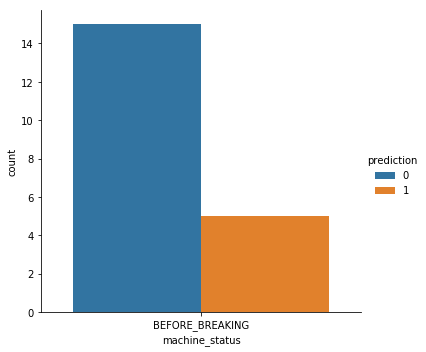

In [88]:
ts_interpolated_test_broken = ts_interpolated_test[ts_interpolated_test['machine_status'] == 'BEFORE_BREAKING']

#sns.violinplot(x='machine_status', y='prediction', data=ts_interpolated_test_broken)

sns.catplot(x='machine_status', data=ts_interpolated_test_broken, hue = "prediction", kind="count")
grouped = ts_interpolated_test_broken.groupby(['machine_status'])
grouped['prediction'].value_counts()

#some breakdowns get detected before they occur

In [89]:
list(ts_broken.index)

[Timestamp('2018-04-12 21:55:00'),
 Timestamp('2018-04-18 00:30:00'),
 Timestamp('2018-05-19 03:18:00'),
 Timestamp('2018-05-25 00:30:00'),
 Timestamp('2018-06-28 22:00:00'),
 Timestamp('2018-07-08 00:11:00'),
 Timestamp('2018-07-25 14:00:00')]

In [91]:
ts_interpolated_test['2018-07-25 13:55:00':'2018-07-25 14:05:00']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,machine_status_new,anomaly_score,decision_function,prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-25 13:55:00,2.321759,45.789930,52.99479,44.010410,435.379028,73.42412,14.395250,16.20370,15.69734,15.11863,...,45.42824,247.9745,65.68287,1000.0,195.3125,BEFORE_BREAKING,1,1,0.141327,0
2018-07-25 13:56:00,2.313889,45.833330,53.03819,43.923610,71.464119,73.00980,14.366320,16.21094,15.69734,15.12587,...,45.13889,252.3148,69.15509,1000.0,198.2060,BEFORE_BREAKING,1,1,0.111657,0
2018-07-25 13:57:00,2.315856,45.833332,53.03819,43.923611,3.336227,72.47576,14.330150,16.16030,15.76968,15.16204,...,44.84954,253.1829,71.46991,1000.0,202.8356,BEFORE_BREAKING,1,1,0.101572,0
2018-07-25 13:58:00,2.322743,45.833330,52.99479,43.923610,3.336227,70.48889,14.460360,16.16030,15.73351,15.01013,...,44.84954,249.1319,72.33796,1000.0,206.8866,BEFORE_BREAKING,1,1,0.109303,0
2018-07-25 13:59:00,2.315856,45.789930,53.03819,43.880210,3.336227,68.74365,14.438660,16.07350,15.53096,15.05353,...,44.84954,244.5023,72.62731,1000.0,209.7801,BEFORE_BREAKING,1,1,0.105376,0
2018-07-25 14:00:00,2.318808,45.833332,52.99479,43.880210,420.503448,72.52040,14.185470,16.24711,15.69734,15.05353,...,43.98148,230.3241,69.73380,1000.0,205.7292,BROKEN,1,1,0.142882,0
2018-07-25 14:01:00,2.318808,45.833332,52.99479,43.880210,420.503448,72.52040,14.185470,16.24711,15.69734,15.05353,...,43.98148,230.3241,69.73380,1000.0,205.7292,RECOVERING,1,1,0.142882,0
2018-07-25 14:02:00,2.252893,45.833332,53.03819,43.880210,55.515045,72.44621,14.438660,16.16753,15.69734,15.08247,...,43.69213,226.2731,68.28703,1000.0,202.8356,RECOVERING,1,1,0.113192,0
2018-07-25 14:03:00,2.244039,45.833332,53.03819,43.836800,3.104745,70.96387,14.322920,16.13136,15.65393,15.08970,...,43.69213,221.9329,67.12963,1000.0,201.0995,RECOVERING,1,1,0.099651,0


In [93]:
ts_interpolated_test['2018-07-08 00:08:00':'2018-07-08 00:14:00']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,machine_status_new,anomaly_score,decision_function,prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-08 00:08:00,0.305961,45.35590,52.99479,45.616318,552.314800,99.584210,0.028935,0.036169,0.028935,0.007234,...,45.428240,107.34950,46.58565,205.7292,189.5255,BEFORE_BREAKING,1,-1,-0.021597,1
2018-07-08 00:09:00,1.172685,45.22569,53.03819,45.616320,550.463000,59.603460,0.028935,0.028935,0.028935,0.007234,...,44.560180,96.64352,45.42824,196.4699,174.1898,BEFORE_BREAKING,1,-1,-0.017592,0
2018-07-08 00:10:00,0.000000,45.22569,52.95139,45.442710,490.046300,9.139087,0.028935,0.028935,0.028935,0.007234,...,43.981480,98.09028,44.84954,195.0231,176.7940,BEFORE_BREAKING,1,-1,-0.028695,1
2018-07-08 00:11:00,0.001968,45.13889,52.90799,45.355900,500.000000,1.401310,0.028935,0.036169,0.036169,0.007234,...,43.402780,99.53703,44.84954,192.1296,174.7685,BROKEN,1,-1,-0.043266,1
2018-07-08 00:12:00,0.001968,45.09549,52.90799,45.312500,378.177100,0.214865,0.028935,0.036169,0.028935,0.007234,...,43.113430,99.53703,43.98148,189.5255,170.4282,RECOVERING,1,-1,-0.028227,1
2018-07-08 00:13:00,0.001968,45.09549,52.90799,45.312500,202.063100,0.033991,0.028935,0.028935,0.028935,0.007234,...,42.534721,100.98380,43.98148,185.1852,166.3773,RECOVERING,1,-1,-0.033811,1
2018-07-08 00:14:00,0.001968,45.13889,52.99479,45.225690,201.252869,0.005212,0.014468,0.028935,0.028935,0.007234,...,41.956020,97.51157,43.69213,177.9514,160.8796,RECOVERING,1,-1,-0.027585,1


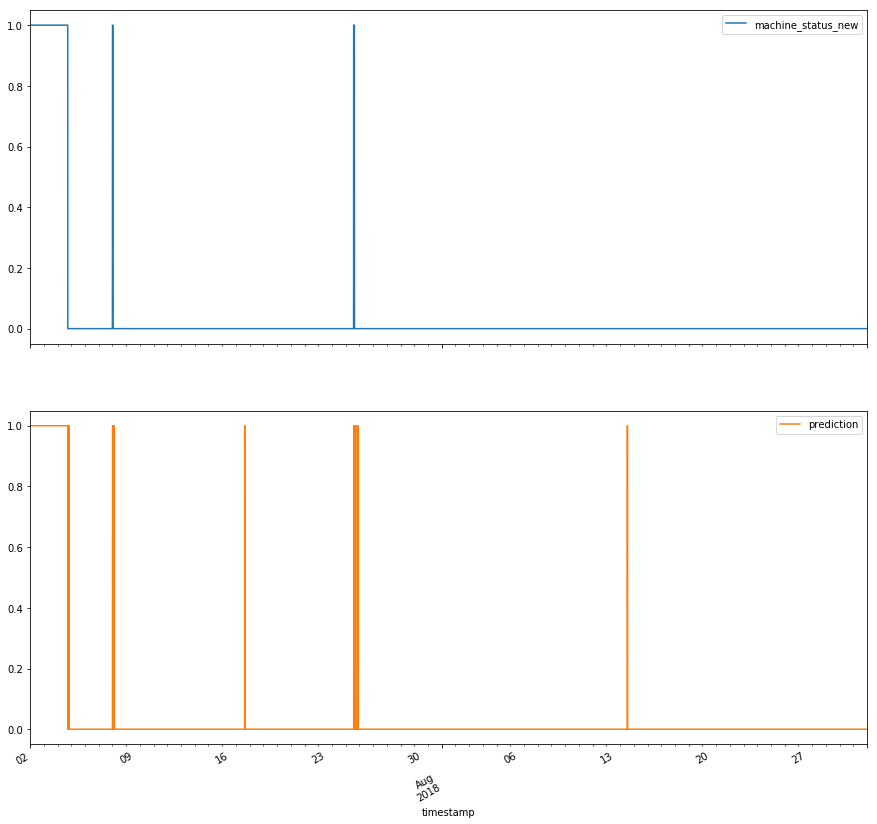

In [30]:
defect_plot = ts_interpolated_test[['machine_status_new','prediction']].plot(figsize=(15, 15), subplots=True)
#blue: actual breakdowns on 7/8 and 7/25
#orange: predicted abnormalities, 2 false positives

In [95]:
#predicts one of two test breakdowns (2018-07-08) before it occurs, there are however false positives

In [96]:
#refine using the top nine feature subset from random forest

#sensor_10, 00, 13, 07, 01, 39, 47, 51, 04

In [97]:
feature_subset = ['sensor_00', 'sensor_10', 'sensor_13', 'sensor_07', 'sensor_01', 'sensor_39', 'sensor_47', 'sensor_51', 'sensor_04','machine_status']

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


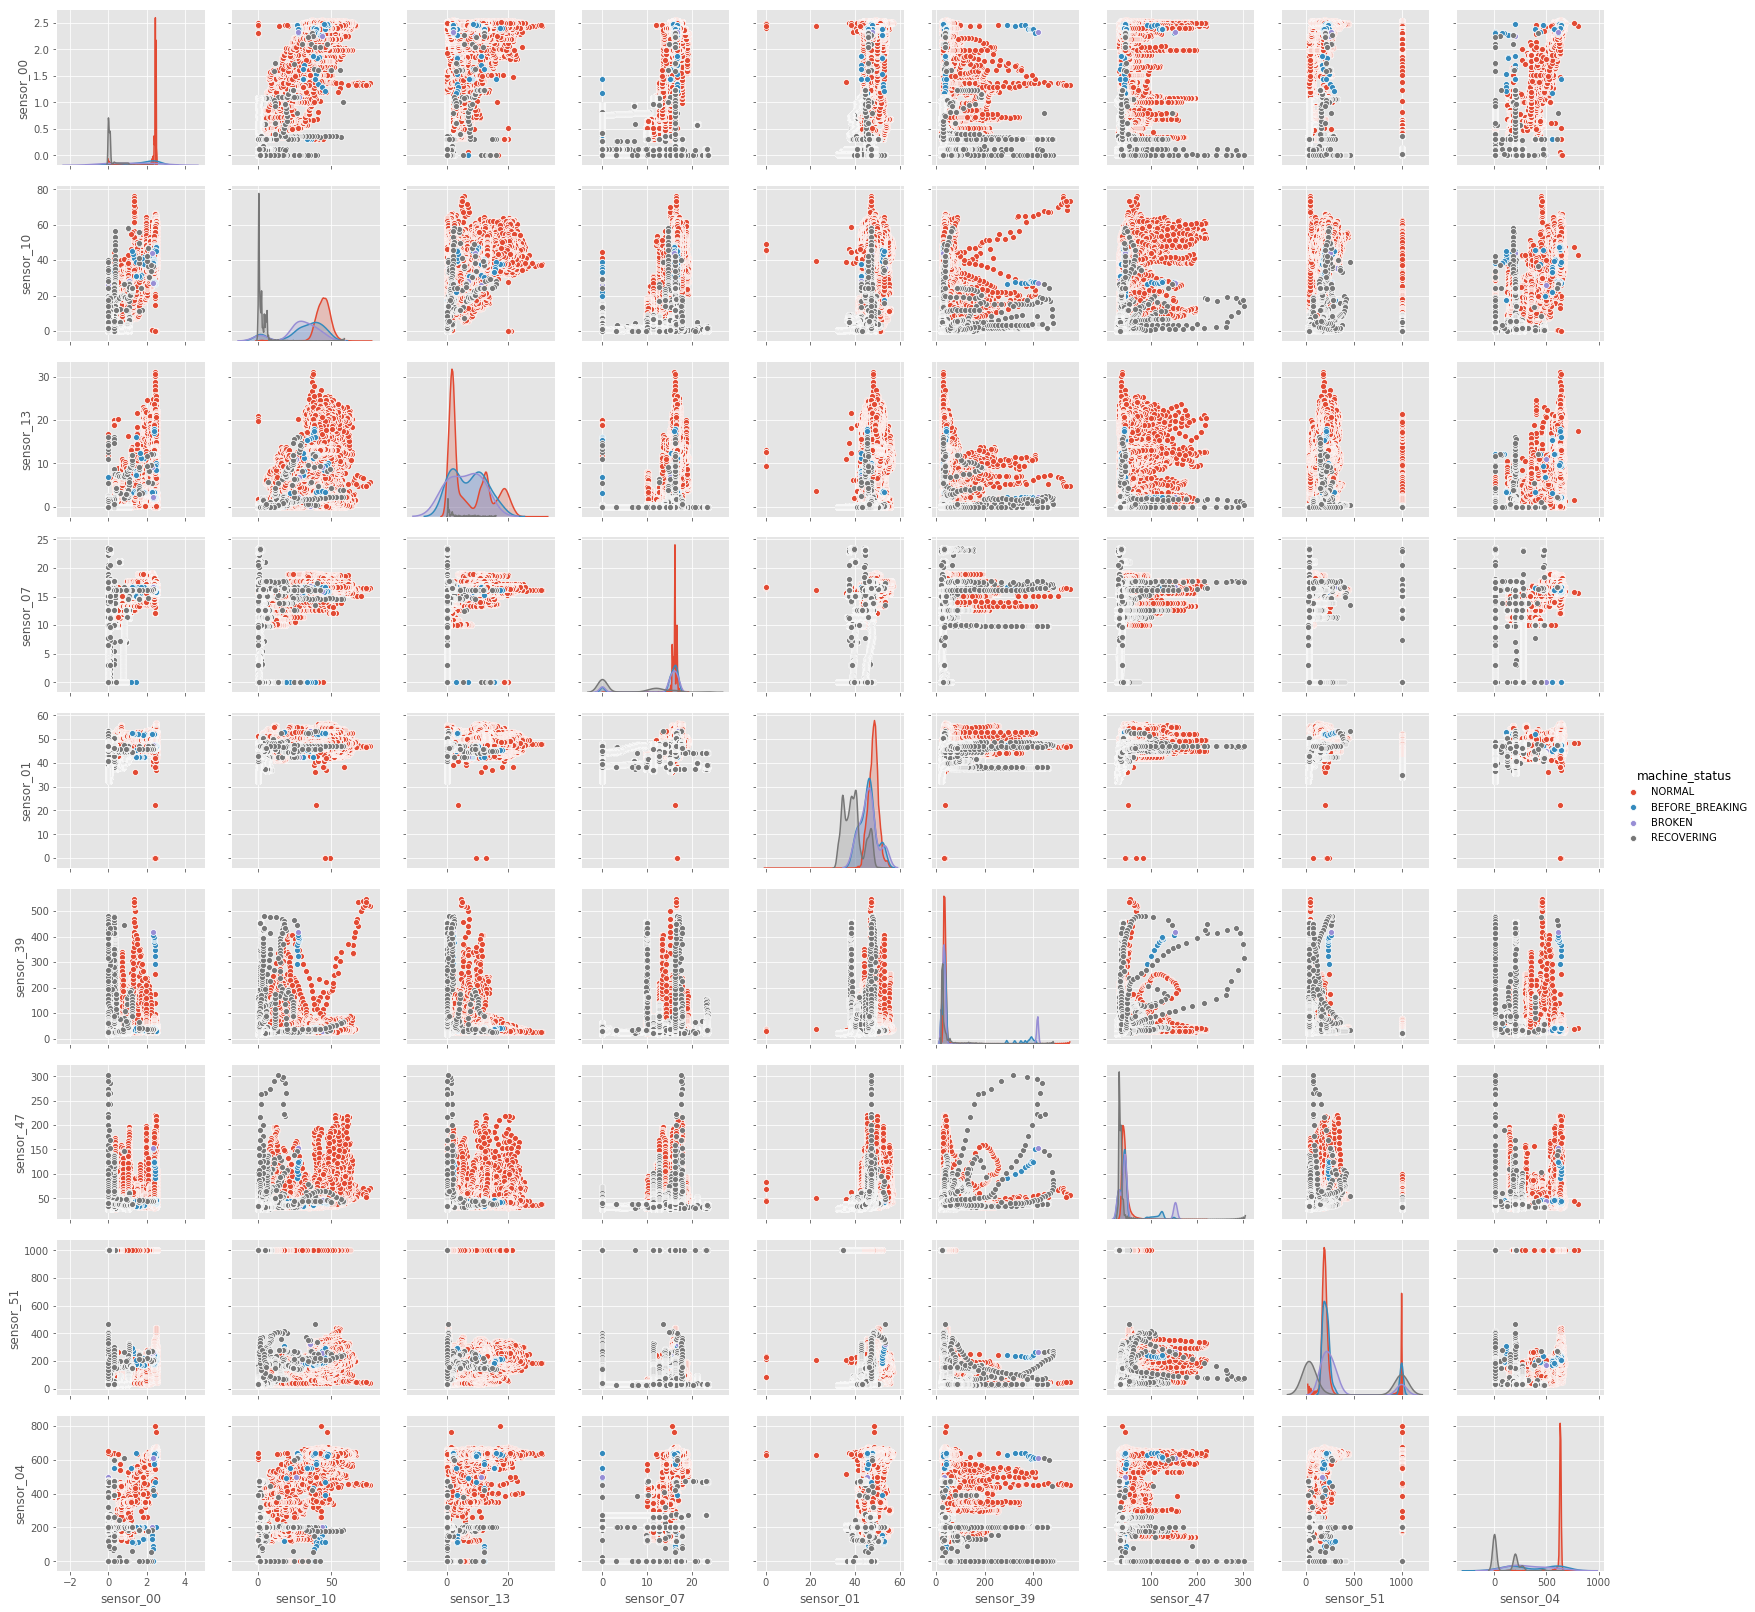

In [35]:
matplotlib.style.use('ggplot')

sns_plot = sns.pairplot(ts_interpolated[feature_subset], hue='machine_status')

In [36]:
sns_plot.savefig("craftworks_selected_vars_output.png")

In [100]:
#interesting patterns for sensors 39 and 47!

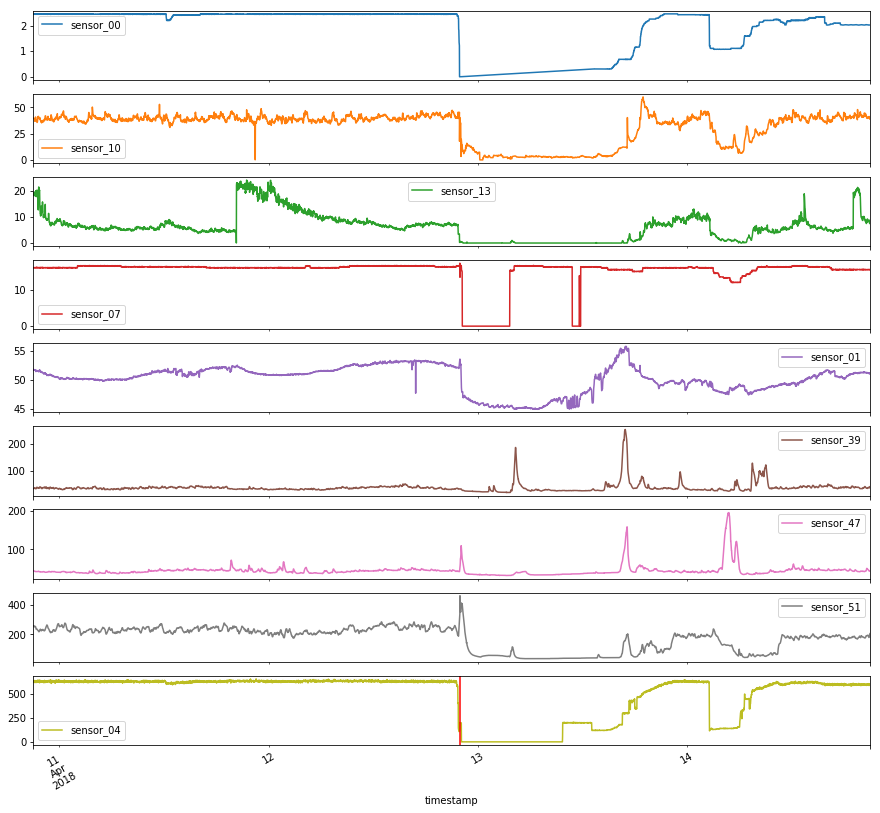

In [101]:
#checking selected features in the context of a breakdown

ts_defect_3 = ts_interpolated['2018-04-10 21:00:00':'2018-04-14 21:00:00'][feature_subset]
defect_plot = ts_defect_3.plot(figsize=(15, 15), subplots=True)

#label breakdown
pp.axvline(pd.Timestamp(list(ts_broken.index)[0]),color='r')

#all seem to vary around breakdown

In [109]:
#go back to 3 classes:
#try random forest, adabost, svm and knn

In [110]:
def make_status_abnormal_3classes(alarms):
    if np.any(alarms == 'BEFORE_BREAKING'):
        return 1
    if np.any(alarms == 'BROKEN'):
        return 1
    if np.any(alarms == 'NORMAL'):
        return 0
    if np.any(alarms == 'RECOVERING'):
        return 2

In [111]:
ts_interpolated['machine_status_new'] = ts_interpolated['machine_status'].apply(make_status_abnormal_3classes)

In [112]:
ts_interpolated['machine_status_new'].value_counts()

0    205766
2     14477
1        77
Name: machine_status_new, dtype: int64

In [113]:
ts_interpolated_train = ts_interpolated['2018-04-01':'2018-07-01']

In [114]:
ts_interpolated_test = ts_interpolated['2018-07-02':]

In [116]:
#feature_subset.remove('machine_status')
#use top 9 features
feature_subset

['sensor_00',
 'sensor_10',
 'sensor_13',
 'sensor_07',
 'sensor_01',
 'sensor_39',
 'sensor_47',
 'sensor_51',
 'sensor_04']

In [46]:
#from imblearn.over_sampling import SMOTE

#y_train = ts_interpolated_train['machine_status_new']
#X_train = ts_interpolated_train[feature_subset]

#sm = SMOTE(random_state=42, ratio = 0.5)
#X_train, y_train = sm.fit_sample(X_train, y_train)

##tried, but does not really help


In [119]:
#resample to make all classes contain equal numbers of examples. 
from sklearn.utils import resample
ts_interpolated_train_majority1 = ts_interpolated_train[ts_interpolated_train.machine_status_new==0]
ts_interpolated_train_minority = ts_interpolated_train[ts_interpolated_train.machine_status_new==1]
ts_interpolated_train_majority2 = ts_interpolated_train[ts_interpolated_train.machine_status_new==2]

# Downsample majority class
df_majority_downsampled1 = resample(ts_interpolated_train_majority1, 
                                 replace=False,    # sample without replacement
                                 n_samples=55,     # to match minority class
                                 random_state=123) # reproducible results
df_majority_downsampled2 = resample(ts_interpolated_train_majority2, 
                                 replace=False,    # sample without replacement
                                 n_samples=55,     # to match minority class
                                 random_state=123) 
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled1, df_majority_downsampled2, ts_interpolated_train_minority])
 
# Display new class counts
df_downsampled.machine_status_new.value_counts()

2    55
1    55
0    55
Name: machine_status_new, dtype: int64

In [120]:
#df_downsampled 165 rows

In [121]:
#random forest on subset with and without downsampling

In [122]:
X_train = ts_interpolated_train[feature_subset]
X_test = ts_interpolated_test[feature_subset]
y_train = ts_interpolated_train['machine_status_new']
y_test = ts_interpolated_test['machine_status_new']

In [123]:
y_train_downsampled = df_downsampled['machine_status_new']
X_train_downsampled = df_downsampled[feature_subset]


In [124]:
clf_rf_2 = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=10, class_weight="balanced")
clf_rf_2_down = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=10)

In [125]:
clf_rf_2.fit(X_train, y_train)
clf_rf_2_down.fit(X_train_downsampled, y_train_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [126]:
y_pred_rf_2 = clf_rf_2.predict(ts_interpolated_test[feature_subset])
y_pred_rf_2_down = clf_rf_2_down.predict(ts_interpolated_test[feature_subset])

In [133]:
ts_interpolated_test['machine_status_new'].value_counts()

0    83751
2     4067
1       22
Name: machine_status_new, dtype: int64

In [134]:
cnf_matrix_rf_2 = metrics.confusion_matrix(y_test, y_pred_rf_2)
cnf_matrix_rf_2

#class 0 (normal): 99.99% correctly classified
#class 1 (before breaking/ broken): 0% correctly classified
#class 2 (recovering): 98% correctly classified

array([[83733,     0,    18],
       [   22,     0,     0],
       [   71,     0,  3996]])

In [128]:
cnf_matrix_rf_2_down = metrics.confusion_matrix(y_test, y_pred_rf_2_down)
cnf_matrix_rf_2_down

#class 0 (normal): 91.5% correctly classified
#class 1 (before breaking/ broken): 18.2% correctly classified
#class 2 (recovering): 98.6% correctly classified

#downsampling increases the number of broken occurences to be correctly classified, but increases the number of false pos

array([[76638,  6345,   768],
       [   13,     4,     5],
       [    0,    58,  4009]])

In [ ]:
#trying adaboost classifier

In [137]:
from sklearn.ensemble import AdaBoostClassifier

In [138]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada_down = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada.fit(ts_interpolated_train[feature_subset], y_train)
clf_ada_down.fit(X_train_downsampled, y_train_downsampled)  
y_pred_ada = clf_ada.predict(ts_interpolated_test[feature_subset])
y_pred_ada_down = clf_ada_down.predict(ts_interpolated_test[feature_subset])

In [139]:
ts_interpolated_test['machine_status_new'].value_counts()

0    83751
2     4067
1       22
Name: machine_status_new, dtype: int64

In [140]:
cnf_matrix_ada = metrics.confusion_matrix(y_test, y_pred_ada)
cnf_matrix_ada

#class 0 (normal): 96.8% correctly classified
#class 1 (before breaking/ broken): 0% correctly classified
#class 2 (recovering): 98.5% correctly classified

array([[81048,  2370,   333],
       [   20,     0,     2],
       [   49,    13,  4005]])

In [141]:
cnf_matrix_ada_down = metrics.confusion_matrix(y_test, y_pred_ada_down)
cnf_matrix_ada_down

#class 0 (normal): 62.4% correctly classified
#class 1 (before breaking/ broken): 61.1% correctly classified
#class 2 (recovering): 96.6% correctly classified

array([[52219, 31363,   169],
       [    5,    11,     6],
       [    0,   136,  3931]])

In [142]:
#svm
from sklearn import svm
from sklearn.svm import SVC


In [143]:
#scale for SVM
from sklearn.preprocessing import MinMaxScaler
#entire dataset
#scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
#X_train_sc = scaling.transform(X_train)
#X_test_sc = scaling.transform(X_test)

#downsampled dataset
scaling_down = MinMaxScaler(feature_range=(-1,1)).fit(X_train_downsampled)
X_train_sc_down = scaling_down.transform(X_train_downsampled)
X_test_sc = scaling_down.transform(X_test)



In [144]:
#clf_svm = svm.SVC(kernel='poly', C = 0.00001, gamma = 1, class_weight = 'balanced')
clf_svm_down = svm.SVC(kernel='poly', C = 0.00001, gamma = 1)

#clf_svm.fit(X_train_sc, y_train)  
clf_svm_down.fit(X_train_sc_down, y_train_downsampled)  

#y_pred_svm = clf_svm.predict(X_test_sc)
y_pred_svm_down = clf_svm_down.predict(X_test_sc)

In [149]:
ts_interpolated_test['machine_status_new'].value_counts()

0    83751
2     4067
1       22
Name: machine_status_new, dtype: int64

In [148]:
#cnf_matrix_svm = metrics.confusion_matrix(y_test, y_pred_svm)
cnf_matrix_svm_down = metrics.confusion_matrix(y_test, y_pred_svm_down)
cnf_matrix_svm_down

#class 0 (normal): 95.1% correctly classified
#class 1 (before breaking/ broken): 77.3% correctly classified
#class 2 (recovering): 94.4% correctly classified

array([[79628,  4083,    40],
       [    5,    17,     0],
       [    0,   229,  3838]])

In [147]:
print(classification_report(y_test, y_pred_svm_down))

             precision    recall  f1-score   support

          0       1.00      0.95      0.97     83751
          1       0.00      0.77      0.01        22
          2       0.99      0.94      0.97      4067

avg / total       1.00      0.95      0.97     87840



In [67]:
#breakdown was correctly predicted in both cases before it occured, but 10% false positive alarms during normal and recovering